# Importing Libraries

In [1]:
# Core Data Manipulation and ML
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from nltk.corpus import stopwords
import nltk

# Configure visualization settings
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

# Downloading dataset

In [ ]:
data = pd.read_csv("data/preprocessed_reviews.csv")

In [5]:
data = data.dropna(subset=['STREM+ZEM'])
print(f"Data size after dropping missing comments: {len(data)}")

Data size after dropping missing comments: 15151


In [6]:
sentiment_map = {1: 'Positive', 0: 'Negative', 2: 'Neutral'}
data['Sentiment_Label'] = data['Sentiment'].map(sentiment_map)

In [7]:
print("\nCleaned Data Head:")
print(data[['STREM+ZEM', 'Sentiment', 'Sentiment_Label']].head())


Cleaned Data Head:
                                           STREM+ZEM  Sentiment  \
0                                          evet anla          1   
1  önce al cihaz ense sakal tüket numara sıfır ya...          1   
2  ürün başarı sakal kes başlık sayı fazla olabil...          1   
3                     önce aynı al güzel kalite ürün          1   
4      erkek kuaför ense sıfır sakal traş uygun ürün          1   

  Sentiment_Label  
0        Positive  
1        Positive  
2        Positive  
3        Positive  
4        Positive  


# EDA

/tmp/ipython-input-3322093239.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Sentiment_Label', data=data,


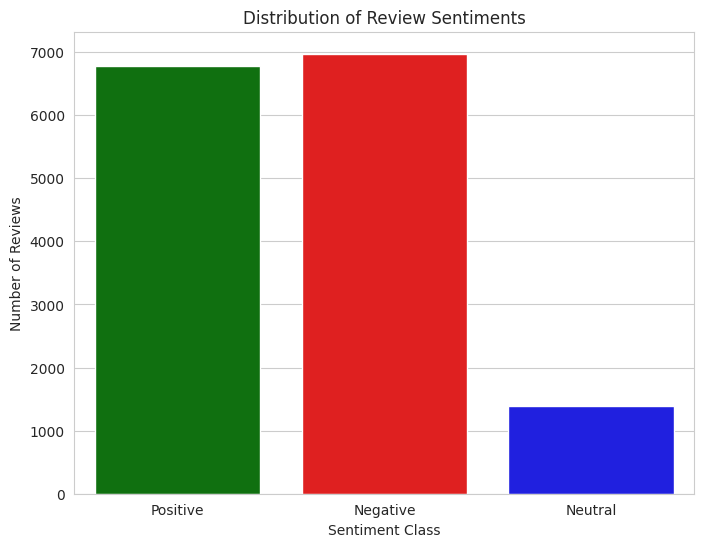

In [9]:
plt.figure(figsize=(8, 6))
# Plot based on the new readable label column
sns.countplot(x='Sentiment_Label', data=data,
              order=['Positive', 'Negative', 'Neutral'],
              palette={'Positive': 'green', 'Negative': 'red', 'Neutral': 'blue'})
plt.title('Distribution of Review Sentiments')
plt.xlabel('Sentiment Class')
plt.ylabel('Number of Reviews')
plt.show()

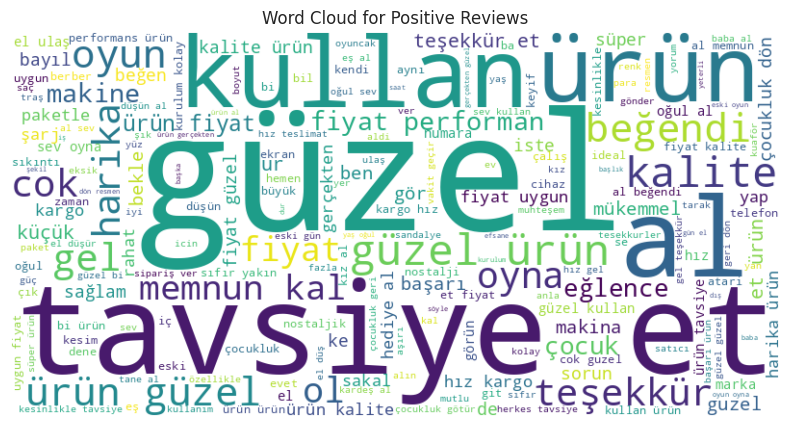

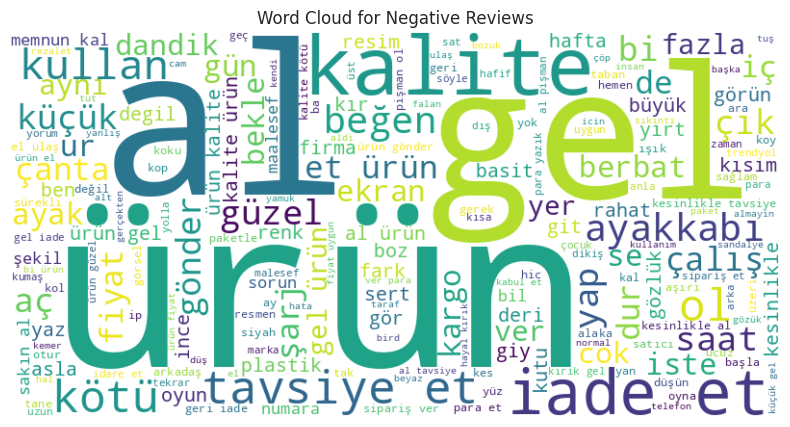

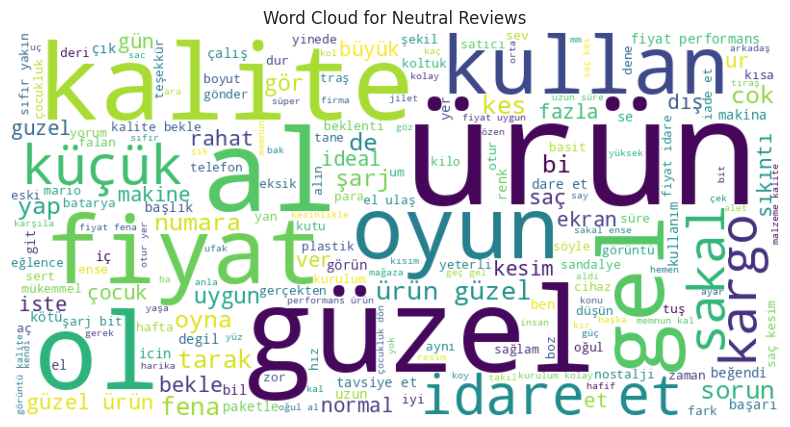

In [10]:
def create_word_cloud(sentiment_label):
    # Filter data for the specific sentiment
    subset = data[data['Sentiment_Label'] == sentiment_label]

    # Concatenate all text from the STREM+ZEM column
    text = ' '.join(review for review in subset['STREM+ZEM'].astype(str))

    # Generate the Word Cloud
    wordcloud = WordCloud(
        background_color='white',
        width=800, height=400
    ).generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'Word Cloud for {sentiment_label} Reviews')
    plt.show()

create_word_cloud('Positive')
create_word_cloud('Negative')
create_word_cloud('Neutral')

# TF_IDF Vectorizer for Each Sentiment

In [15]:
def get_top_tfidf_words_by_sentiment(df, sentiment_label, text_column='STREM+ZEM', n=20):
    """
    Calculates and returns the top N words based on mean TF-IDF score
    for a specific sentiment subset.
    """
    # Filter the DataFrame by the specified sentiment
    subset = df[df['Sentiment_Label'] == sentiment_label]

    # Initialize and apply TF-IDF Vectorizer
    # max_features is set to 5000 to limit the vocabulary size for efficiency
    tfidf_vectorizer = TfidfVectorizer(max_features=10000)
    X = tfidf_vectorizer.fit_transform(subset[text_column])

    # Get feature names (words)
    feature_names = np.array(tfidf_vectorizer.get_feature_names_out())

    # Calculate the mean TF-IDF score for each word across the subset
    # .A1 converts the matrix output to a 1D numpy array
    avg_tfidf_scores = X.mean(axis=0).A1

    # Create a DataFrame for sorting
    tfidf_df = pd.DataFrame({
        'word': feature_names,
        'tfidf_mean': avg_tfidf_scores
    })

    # Sort and get the top N words
    top_words_df = tfidf_df.sort_values(by='tfidf_mean', ascending=False).head(n)

    return top_words_df

In [17]:
positive_top_words = get_top_tfidf_words_by_sentiment(data, 'Positive')
negative_top_words = get_top_tfidf_words_by_sentiment(data, 'Negative')
neutral_top_words = get_top_tfidf_words_by_sentiment(data, 'Neutral')

In [18]:
print(positive_top_words)

          word  tfidf_mean
1459     güzel    0.087945
3635      ürün    0.083204
1203     fiyat    0.052306
139         al    0.044638
1135        et    0.042038
2000    kullan    0.036818
1771    kalite    0.036138
3043   tavsiye    0.035392
3118  teşekkür    0.027976
557    beğendi    0.027831
1504    harika    0.022172
2235    memnun    0.021033
778        cok    0.020743
1258       gel    0.020714
2531      oyun    0.019446
1600       hız    0.018836
3237     uygun    0.018090
2505      oyna    0.017255
2828       sev    0.016816
3561  çocukluk    0.016512


In [19]:
print(negative_top_words)

         word  tfidf_mean
4913     ürün    0.055352
2486   kalite    0.048805
1384       et    0.044151
130        al    0.041749
1621      gel    0.041441
3057     kötü    0.028151
2192     iade    0.027152
4440  tavsiye    0.020822
433     beğen    0.019751
3550       ol    0.019046
3778     para    0.018399
3076    küçük    0.017766
2931   kullan    0.016508
1528    fiyat    0.016025
1887   gönder    0.015073
1967      gün    0.014136
4598      ver    0.014057
1987    güzel    0.013773
420    berbat    0.013723
4953     şarj    0.013516


In [20]:
print(neutral_top_words)

        word  tfidf_mean
2208    ürün    0.059403
872    güzel    0.052403
669       et    0.052158
716    fiyat    0.048386
1044  kalite    0.044958
946    idare    0.039383
703     fena    0.037004
1248   küçük    0.030733
92        al    0.028542
753      gel    0.026455
1425      ol    0.026172
1489    oyun    0.023890
1199  kullan    0.023441
1069   kargo    0.019111
493     dare    0.018830
1933   uygun    0.017270
1590   sakal    0.017211
296    bekle    0.016537
841      gör    0.016314
2155   çocuk    0.016215


In [24]:
def plot_top_words(data, title):
    plt.figure(figsize=(12, 8))
    sns.barplot(x='tfidf_mean', y='word', data=data, palette='Spectral')
    plt.title(title, fontsize=16)
    plt.xlabel('Average TF-IDF Score', fontsize=14)
    plt.ylabel('Word', fontsize=14)
    plt.tight_layout()
    plt.show()

/tmp/ipython-input-2290745244.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tfidf_mean', y='word', data=data, palette='Spectral')


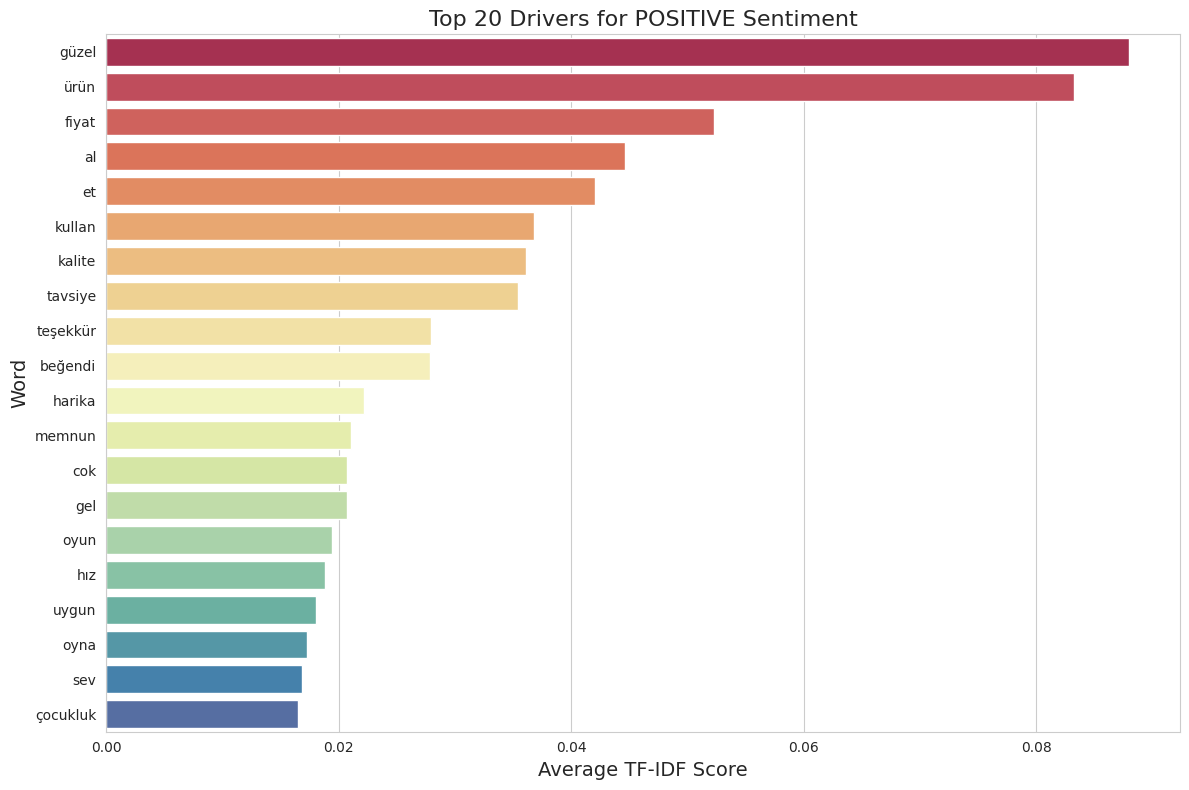

In [25]:
plot_top_words(positive_top_words, 'Top 20 Words for POSITIVE Sentiment')

/tmp/ipython-input-2290745244.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tfidf_mean', y='word', data=data, palette='Spectral')


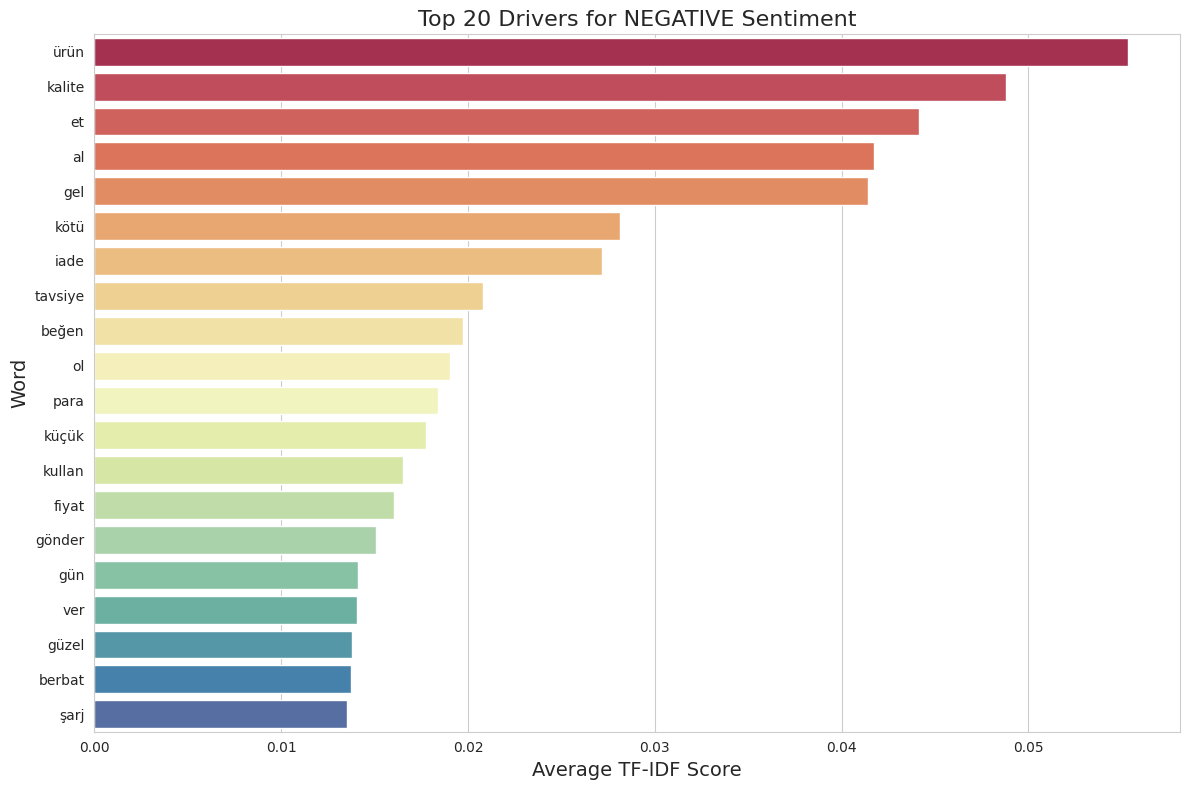

In [26]:
plot_top_words(negative_top_words, 'Top 20 Words for NEGATIVE Sentiment')

/tmp/ipython-input-2290745244.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tfidf_mean', y='word', data=data, palette='Spectral')


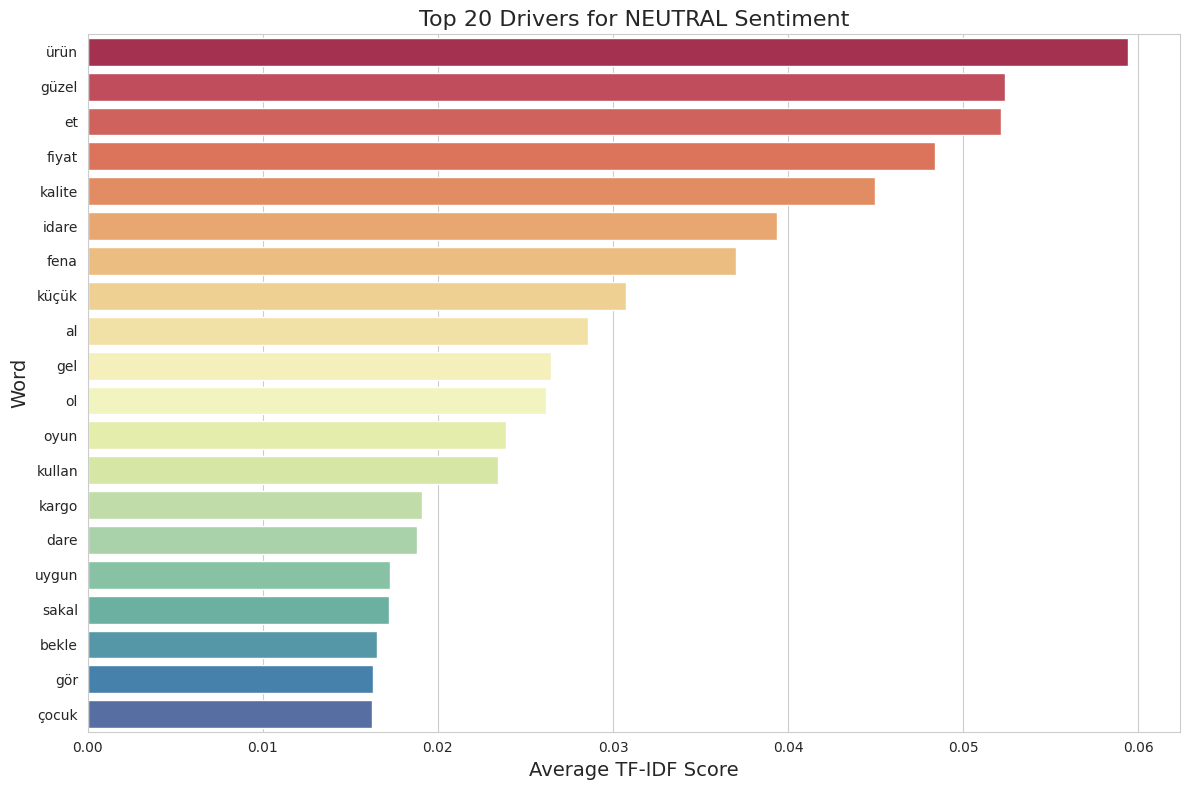

In [27]:
plot_top_words(neutral_top_words, 'Top 20 Words for NEUTRAL Sentiment')